In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

from pmdarima.metrics import smape

import time
import warnings


In [9]:
pd.plotting.register_matplotlib_converters()

symbol = "META"
ticker = yf.Ticker(symbol)
hist = ticker.history(period="1d", start="2021-11-01", end="2023-10-31")
data = hist["Close"]
data.index = pd.DatetimeIndex(data.index).to_period("D")


/tmp/ipykernel_25448/2878122190.py:7: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  data.index = pd.DatetimeIndex(data.index).to_period("D")


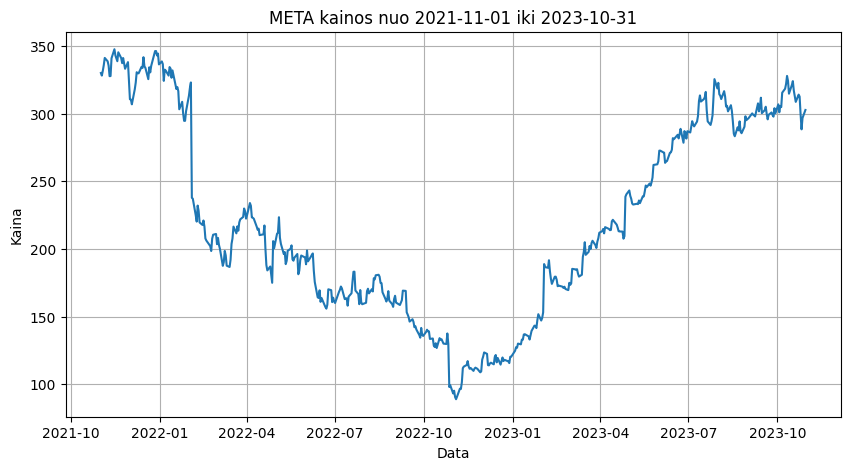

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(data.index.to_timestamp(), data.array)
plt.title("META kainos nuo 2021-11-01 iki 2023-10-31")
plt.xlabel("Data")
plt.ylabel("Kaina")
plt.grid(True)
plt.show()


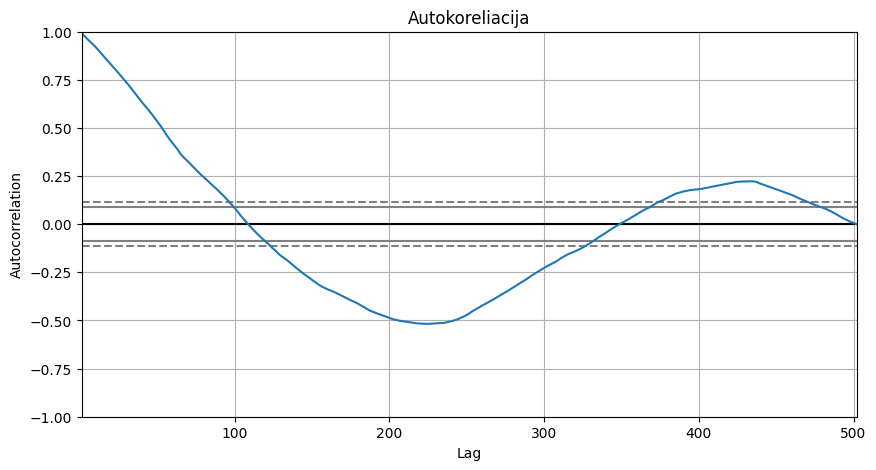

In [11]:
plt.figure(figsize=(10, 5))
pd.plotting.autocorrelation_plot(data)
plt.title("Autokoreliacija")
plt.show()


In [12]:
result = adfuller(data)
print("Dickey-Fuller testas:")
print(f"ADF statistika: {result[0]:.6f}")
print(f"p reikšmė: {result[1]:.6f}")


Dickey-Fuller testas:
ADF statistika: -1.336098
p reikšmė: 0.612500


In [13]:
differenced_data = data.diff().dropna()


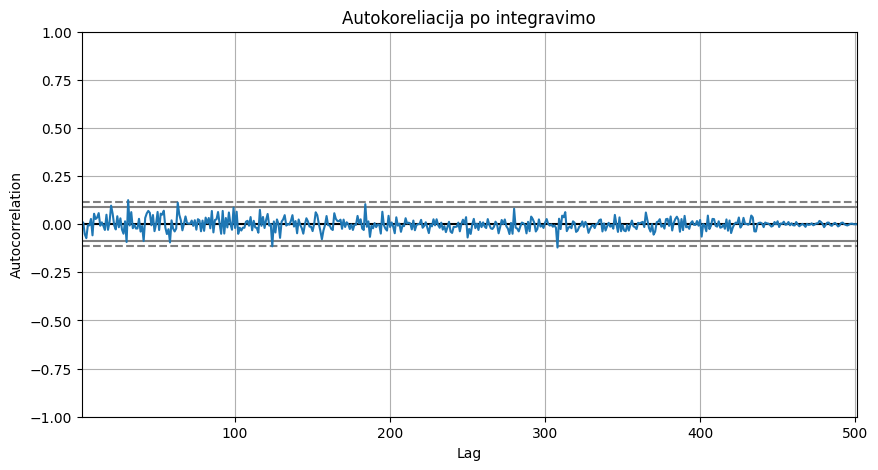

In [14]:
plt.figure(figsize=(10, 5))
pd.plotting.autocorrelation_plot(differenced_data)
plt.title("Autokoreliacija po integravimo")
plt.show()


In [15]:
result_diff = adfuller(differenced_data)
print("Dickey-Fuller testas:")
print(f"ADF statistika: {result_diff[0]:.6f}")
print(f"p reikšmė: {result_diff[1]:.6f}")


Dickey-Fuller testas:
ADF statistika: -22.591880
p reikšmė: 0.000000


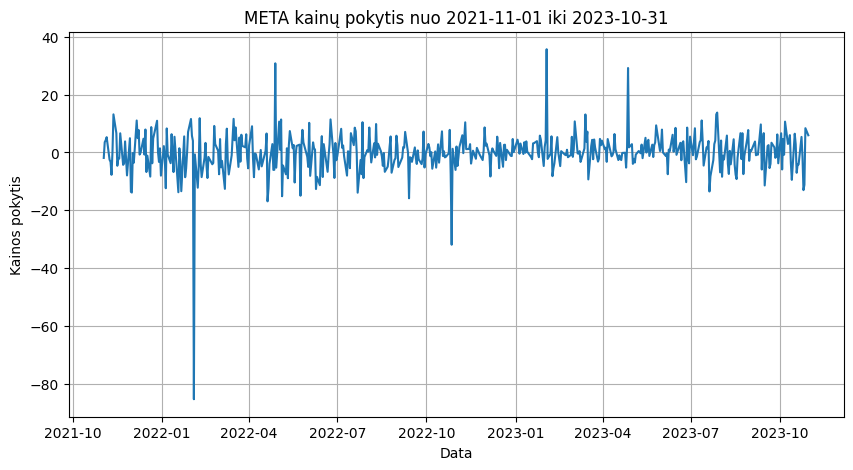

In [16]:
plt.figure(figsize=(10, 5))
plt.plot(differenced_data.index.to_timestamp(), differenced_data.array)
plt.title("META kainų pokytis nuo 2021-11-01 iki 2023-10-31")
plt.xlabel("Data")
plt.ylabel("Kainos pokytis")
plt.grid(True)
plt.show()


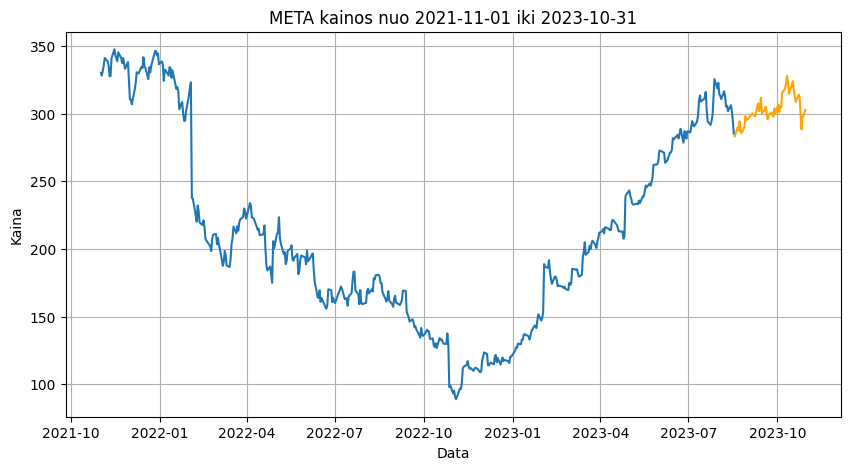

In [17]:
train_size = int(len(data) * 0.9)
train, test = data[:train_size], data[train_size:]

plt.figure(figsize=(10, 5))
plt.plot(train.index.to_timestamp(), train.array)
plt.plot(test.index.to_timestamp(), test.array, color="orange")
plt.title("META kainos nuo 2021-11-01 iki 2023-10-31")
plt.xlabel("Data")
plt.ylabel("Kaina")
plt.grid(True)
plt.show()


In [18]:
start_time = time.time()
forecast_values = []

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    for i in range(len(test)):
        model = ARIMA(train, order=(4, 1, 3))
        model_fit = model.fit()

        forecast = float(model_fit.forecast(steps=1))
        # print(forecast)

        forecast_values.append(forecast)

        train = data[: train_size + i + 1]
        end_time = time.time()

time_taken = end_time - start_time
print("Time taken:", time_taken, "seconds")


Time taken: 27.06386137008667 seconds


In [19]:
df_existing = pd.DataFrame(test)
df_existing.reset_index(drop=False, inplace=True)
df_forecast = pd.DataFrame(forecast_values, columns=["Forecast"])
result = pd.concat([df_existing, df_forecast], axis=1)
result.set_index("Date", inplace=True)


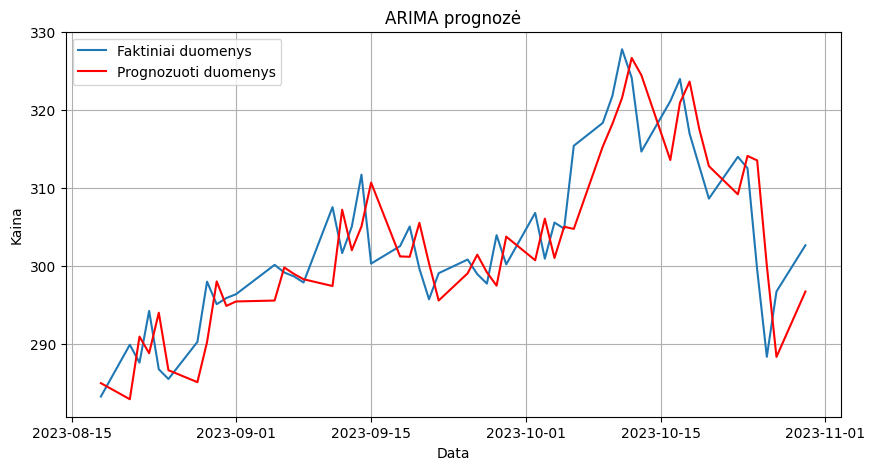

In [20]:
plt.figure(figsize=(10, 5))
plt.plot(result.index.to_timestamp(), result.Close, label="Faktiniai duomenys")
plt.plot(
    result.index.to_timestamp(),
    result.Forecast,
    color="red",
    label="Prognozuoti duomenys",
)
plt.title("ARIMA prognozė")
plt.xlabel("Data")
plt.ylabel("Kaina")
plt.legend()
plt.grid(True)
plt.show()


In [21]:
def verify_fit(test_data, forecasts):
    print(f"Mean squared error: {mean_squared_error(test_data, forecasts)}")
    print(f"SMAPE: {smape(test_data, forecasts)}")
    print(f"MAE: {mean_absolute_error(test_data, forecasts)}")
    print(f"RMSE: {np.sqrt(mean_squared_error(test_data, forecasts))}")
    print(
        f"MAPE: {np.mean(np.abs(forecasts - test_data.values) / np.abs(test_data.values)) * 100}"
    )
    print(
        f"MASE: {np.mean(np.abs(forecasts - test_data.values) / np.std(test_data.values))}"
    )


test = result["Close"]
forecast = result["Forecast"]

verify_fit(test, forecast)


Mean squared error: 33.12820895009499
SMAPE: 1.582043216455937
MAE: 4.802476608049626
RMSE: 5.755710985629403
MAPE: 1.5821530399784092
MASE: 0.45618856463531926
